# Lab 3 — dimensionality reduction

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

In [2]:
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 2

{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}


In [3]:
data = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tag2name = dict(data.map(itemgetter("tagId", "tag")).collect())

## Exercise 3.1

In [4]:
# List of movie ids with tags

scores = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
movies_with_tags = sorted(scores.map(lambda x: x["movieId"]).distinct().collect())

In [5]:
# Matrix dimensions

M = data.count()
N = len(movies_with_tags)

mtx = np.zeros((M, N))

In [6]:
# List of tuples (movieId, [{tagId: 1, relevance: a}, {tagId: 2, relevance: b}, ...])

scores_by_movieId = scores.map(lambda x: (x["movieId"], {"tagId": x["tagId"], "relevance": x["relevance"]})).groupByKey().collect()


In [7]:
# Fill the matrix

for movie_scores in scores_by_movieId:
    movieId = movie_scores[0]
    tag_list = movie_scores[1]
    for tag in tag_list:
        tagId = tag["tagId"]
        relevance = tag["relevance"]
        mtx[tagId-1][movies_with_tags.index(movieId)] = relevance

mtx

array([[0.025  , 0.03975, 0.0435 , ..., 0.042  , 0.05975, 0.05325],
       [0.025  , 0.04375, 0.05475, ..., 0.03175, 0.10375, 0.08625],
       [0.05775, 0.03775, 0.028  , ..., 0.017  , 0.1785 , 0.017  ],
       ...,
       [0.03625, 0.01475, 0.0195 , ..., 0.0095 , 0.51925, 0.01575],
       [0.07775, 0.09025, 0.097  , ..., 0.0755 , 0.067  , 0.1145 ],
       [0.023  , 0.01875, 0.0185 , ..., 0.01625, 0.01725, 0.02175]])

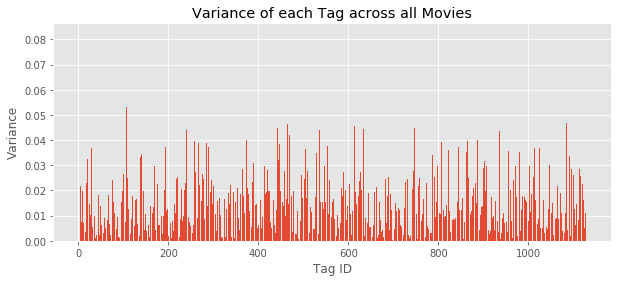

In [8]:
# Plot the variance of each dimension (represented by tags) across all movies

tag_variance = np.var(mtx, axis=1)

plt.figure(figsize=(10, 4))
plt.bar(list(tag2name), tag_variance)
plt.title('Variance of each Tag across all Movies')
plt.xlabel('Tag ID')
plt.ylabel('Variance')
plt.show()

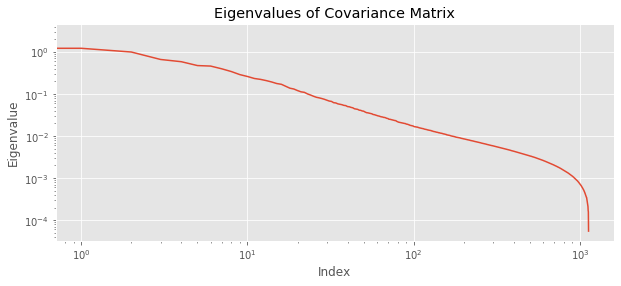

In [9]:
# Plot the eigenvalues of the M × M covariance matrix

covariance_mtx = np.cov(mtx)
eigen_values, eigen_vectors = np.linalg.eigh(covariance_mtx)
eigen_values_sorted = np.sort(eigen_values)[::-1] # Sort descending
eigen_vectors = np.flip(eigen_vectors, axis=1)

plt.figure(figsize=(10, 4))
plt.loglog(eigen_values_sorted)
plt.title('Eigenvalues of Covariance Matrix')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.show()

In [10]:
# Explain the implications for dimensionality reduction

total_variance = sum(eigen_values)
cumulative_variance_ratio = np.cumsum(eigen_values_sorted) / total_variance
num_components_for_2_3_variance = np.argmax(cumulative_variance_ratio > 2/3)

print ("Number of principal components needed to capture 2/3 of the variability:", num_components_for_2_3_variance)

Number of principal components needed to capture 2/3 of the variability: 36


To capture at least 2/3 of the total variability in the tag data, only the first 36 principal components out of a total of 1128 is required. This shows that a significant dimensionality reduction, from 1128 dimensions down to 36, is still able to retain a substantial amount of the total variance in the dataset.

## Exercise 3.2 Concept space

In [11]:
# For the five first principal directions, find the 10 tags with the highest and lowest coordinates in that direction.

first_five_eigen_vectors = eigen_vectors.T[:5]

for idx, principal_direction in enumerate(first_five_eigen_vectors):
    sorted_tags = principal_direction.argsort()
    
    highest_10 = sorted_tags[::-1][:10]
    print("Principal Direction", idx + 1, "\n")
    print("HIGHEST 10")
    for i in range(10):
        print("{:20s}{:20f}".format(tag2name[highest_10[i]+1], principal_direction[highest_10[i]]))
    
    lowest_10 = sorted_tags[:10]
    print("\nLOWEST 10")
    for i in range (10):
        print("{:20s}{:20f}".format(tag2name[lowest_10[i]+1], principal_direction[lowest_10[i]]))

    print("========================================\n")

Principal Direction 1 

HIGHEST 10
talky                           0.104587
social commentary               0.101853
criterion                       0.101389
imdb top 250                    0.099906
great acting                    0.098764
drama                           0.098425
oscar (best directing)            0.097419
bleak                           0.096656
dramatic                        0.096186
cinematography                  0.095898

LOWEST 10
predictable                    -0.083331
so bad it's funny              -0.068450
bad plot                       -0.065058
silly                          -0.061452
silly fun                      -0.060956
horrible                       -0.054783
franchise                      -0.053759
lame                           -0.046250
big budget                     -0.045794
comedy                         -0.045540

Principal Direction 2 

HIGHEST 10
intimate                        0.105640
relationships                   0.087637
criterion     

1. **Principal Direction 1: Quality Drama versus Lowbrow Comedy**
   - **Highest:** This direction is dominated by high-quality drama elements like strong dialogue (talky), social commentary, and excellent cinematography.
   - **Lowest:** In contrast, the negative end includes elements typical of less critically-acclaimed films, such as predictability, poor plots, and slapstick or lowbrow comedy.


2. **Principal Direction 2: Intimate Art House versus Mainstream Action**
   - **Highest:** Focuses on intimate, melancholic, and deep relationship themes, often found in Criterion Collection films or art house cinema.
   - **Lowest:** The opposite end features attributes typical of mainstream action movies, characterized by fast pacing, special effects, and big budgets.


3. **Principal Direction 3: Heartwarming Romance versus Dark Horror**
   - **Highest:** Emphasizes feel-good, sentimental, and romantic movies that are touching and heartwarming.
   - **Lowest:** Contrasted with movies that include horror, weirdness, and disturbing elements, often with a darker and more unsettling tone.


4. **Principal Direction 4: Visual and Sci-Fi Innovation versus Crime Thriller**
   - **Highest:** Highlighting movies that are visually stunning or imaginative, especially within the science fiction genre.
   - **Lowest:** Opposed by films focused on crime, corruption, and darker thriller elements involving police investigations and gangsters.


5. **Principal Direction 5: Suspense and Mystery versus Comedy**
   - **Highest:** Concentrates on thriller and mystery elements, characterized by suspense, conspiracies, and investigative themes.
   - **Lowest:** Directly contrasted with comedic elements, particularly those that are overtly funny, humorous, or part of a comedic cult classic.


These conceptual descriptions summarize the primary themes and styles that are most prominentin each principal direction, helping to delineate the type of movie experiences these dimensions represent.

In [12]:
tags_with_5_principal_coords = {}
for tag in tag2name:
    tags_with_5_principal_coords[tag2name[tag]] = []
    for principal_direction in first_five_eigen_vectors:
        coord = principal_direction[tag-1]
        tags_with_5_principal_coords[tag2name[tag]].append(coord)

In [13]:
# Writing an object to disk

import pickle

with open("tags_with_5_principal_coords.pickle", "wb") as f:
    pickle.dump(tags_with_5_principal_coords, f)

## Exercise 3.3 Movie visualization

In [14]:
# Reading an object from disk

with open("selected-movies.pickle", "rb") as f:
    selected_movies = pickle.load(f, encoding="utf-8")

In [15]:
projections = [
    [np.dot(mtx[:, movies_with_tags.index(movie[0])], first_five_eigen_vectors[i]) for movie in selected_movies] for i in range(5)
]

In [16]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()

Loading BokehJS ...

In [17]:
# Continuous colors
from matplotlib.colors import rgb2hex 
cmap = plt.get_cmap('viridis')

def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

source = ColumnDataSource(
    data={
        "x": projections[0],
        "y": projections[1],
        "name": [x[1] for x in selected_movies],
        "color": [val2rgb(x[2]) for x in selected_movies],
        "rtscore": [x[2] for x in selected_movies]
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
        ("RT Score", "@rtscore")
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=840, plot_height=360, tools=tools, title="Mouse over the dots")
p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
show(p, notebook_handle=True)

*Based on your knowledge of these movies and information that you can get from the web, explain the coordinates of a few of the movies.*

1. **Principal Direction 1: Quality Drama versus Lowbrow Comedy**
   - **Highest:** This direction is dominated by high-quality drama elements like strong dialogue (talky), social commentary, and excellent cinematography.
   - **Lowest:** In contrast, the negative end includes elements typical of less critically-acclaimed films, such as predictability, poor plots, and slapstick or lowbrow comedy.


2. **Principal Direction 2: Intimate Art House versus Mainstream Action**
   - **Highest:** Focuses on intimate, melancholic, and deep relationship themes, often found in Criterion Collection films or art house cinema.
   - **Lowest:** The opposite end features attributes typical of mainstream action movies, characterized by fast pacing, special effects, and big budgets.

This indicates that movies plotted on the right side (which score higher on the first principal direction) are well-executed and positively reviewed, while those on the left are considered frivolous. Similarly, films positioned at the top are slow and emotive, whereas those at the bottom are fast-paced action movies.

This explains why "Wild Strawberries", a slow-paced, emotional, and critically acclaimed film, is in the top right, "City of God", which is neither action-packed nor overly sentimental but still highly regarded, is in the center right, and "The Matrix," a popular action film, is located in the bottom right of the plot. "Battleship", a movie known for its predictable plot, can be seen on the left side of the plot.

*How do the PCA directions correlate with the Rotten Tomatoes score?*

The Rotton Tomatoes score seems to show a strong correlation with the first principal direction, which is not surprising as the highest and lowest tags in the first principal direction indicates popularity within the general public. There seems to be little to no correlation with the second principal direction.

## Exercise 3.4 Movie visualization using t-SNE vs. PCA

In [18]:
# Random sample of 1000 movies

import random
np.random.seed(123)
random_movies = random.sample(movies_with_tags, 1000)

In [19]:
projections_50 = [
    [np.dot(mtx[:, movies_with_tags.index(movieId)], eigen_vectors[i]) for movieId in random_movies] for i in range(50)
]

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(init="pca")
projections_50_embedded = tsne.fit_transform(np.transpose(projections_50))
projections_50_embedded.shape

(1000, 2)

In [21]:
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
movies_list = movies.collect()

In [22]:
def get_movie_tuple(movie_id, movie_list):
    for movie_tuple in movie_list:
        if movie_tuple[0] == movie_id:
            return movie_tuple
    return None

movies_top_5_tags = []
for movieId in random_movies:
    movie_tuple = get_movie_tuple(movieId, scores_by_movieId)
    sorted_tags = sorted(movie_tuple[1], key=lambda x: x['relevance'], reverse=True)
    top_tags = sorted_tags[:5]
    result = ""
    for tag in top_tags:
        result += tag2name[tag["tagId"]]
        result += ", "
    movies_top_5_tags.append(result[:-2])

In [23]:
# Create an interactive plot that displays the t-SNE 2D-projection of all the movies

def get_title_by_id(movies, movie_id):
    for movie in movies:
        if movie['movieId'] == movie_id:
            return movie['title']

source = ColumnDataSource(
    data={
        "x": [x[0] for x in projections_50_embedded],
        "y": [x[1] for x in projections_50_embedded],
        "name": [get_title_by_id(movies_list, x) for x in random_movies],
        "color": [val2rgb(1) for x in random_movies],
        "top_5_tags": movies_top_5_tags,
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
        ("Top 5 tags", "@top_5_tags"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=860, plot_height=500, tools=tools, title="Mouse over the dots")
p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
show(p, notebook_handle=True)

In [24]:
# Create an interactive plot that displays the PCA 2D-projection of all the movies (projections on the first 2 principal directions)

projections_2 = [
    [np.dot(mtx[:, movies_with_tags.index(movieId)], eigen_vectors[i]) for movieId in random_movies] for i in range(2)
]

source = ColumnDataSource(
    data={
        "x": projections_2[0],
        "y": projections_2[1],
        "name": [get_title_by_id(movies_list, x) for x in random_movies],
        "color": [val2rgb(1) for x in random_movies],
        "top_5_tags": movies_top_5_tags,
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
        ("Top 5 tags", "@top_5_tags"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=860, plot_height=500, tools=tools, title="Mouse over the dots")
p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
show(p, notebook_handle=True)

*What differences do you observe between the t-SNE plot and the PCA plot? In particular, in which of the plots do you see more interpretable clusters of movies? Can you explain why?*

The t-SNE plot seems to show a large spread out cloud of points with no correlation between the 2 embedded principal directions. However, the PCA plot shows a correlation between its 2 principal directions. Movies in the PCA plot who score higher in the first principal direction (right side of the plot) seems to score lower in the second principal direction (bottom side of the plot). The t-SNE plot does seem to have more interpretable clusters of movies, as seen from the bottom left and right side of the plot, as compared to the PCA plot.

PCA is a linear technique that may not effectively capture complex, non-linear relationships. This results in a plot where correlations between principal directions can be observed, but it might lack clear, distinct clusters if the data structure is non-linear.

t-SNE, on the other hand, is a non-linear technique for preserving the local structure of the data and capturing non-linear relationships, which makes it good at forming interpretable clusters. The axes in a t-SNE plot do not represent directions of maximum variance but are instead focused on grouping similar data points closely together, thus often resulting in a more clustered distribution that can reveal intricate patterns within the data. t-SNE tends to create more interpretable clusters especially in complex datasets, as it can uncover hidden structures and relationships that PCA might miss.